<a href="https://colab.research.google.com/github/FrancoGalfrascoli/CSE---437-/blob/main/lab6_nonlinear.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 6: Non-linear function approximation

## Exercise 1: Q-Learning with a Neural Network (PyTorch) on MountainCar

**Objective:**
Implement **Q-learning** with a **PyTorch neural network** to solve `MountainCar-v0`. You will approximate Q(s, a) with a small MLP, train it from batches of transitions sampled from a replay buffer, and evaluate the learned policy.

---

## Environment
- **Gym** environment: `MountainCar-v0`
- **State**: continuous (position, velocity) → shape `(2,)`
- **Actions**: {0: left, 1: no push, 2: right}
- **Reward**: -1 per step until the goal (`position >= 0.5`)
- **Episode limit**: 500 steps
- **Goal**: reduce steps-to-goal and improve return over training

---

## What You Must Implement

### 1) Q-Network (PyTorch)
Create a small MLP `QNetwork` that maps `state -> Q-values for 3 actions`.
- Inputs: `(batch_size, 2)` float32
- Outputs: `(batch_size, 3)` Q-values
- Suggested architecture: `2 → 64 → 3` with ReLU
- Initialize weights reasonably (PyTorch defaults are fine)

### 2) Replay Buffer
A cyclic buffer to store transitions `(s, a, r, s_next, done)`:
- `append(s, a, r, s_next, done)`
- `sample(batch_size)` → tensors ready for PyTorch (float32 for states, int64 for actions, float32 for rewards/done)

### 3) ε-Greedy Policy
- With probability `epsilon`: pick a random action
- Otherwise: `argmax_a Q(s, a)` from the current network
- Use **decaying ε** (e.g., from 1.0 down to 0.05 over ~20–50k steps)

### 4) Q-Learning Target and Loss
For a sampled batch:
- Compute `q_pred = Q(s).gather(1, a)`  (shape `(batch, 1)`)
- Compute target:
  - If `done`: `target = r`
  - Else: `target = r + gamma * max_a' Q(s_next, a').detach()`
- Loss: Mean Squared Error (MSE) between `q_pred` and `target`

> **Stabilization (recommended)**: Use a **target network** `Q_target` (periodically copy weights from `Q_online`) to compute the max over next-state actions. Update every `target_update_freq` steps.

### 5) Deep Q-learning method
- For each environment step:
  1. Select action with ε-greedy
  2. Step the env, store transition in buffer
  3. If `len(buffer) >= batch_size`:
     - Sample a batch
     - Compute `q_pred`, `target`
     - Backprop: `optimizer.zero_grad(); loss.backward(); optimizer.step()`
     - (Optional) gradient clipping (e.g., `clip_grad_norm_` at 10)
  4. Periodically update `Q_target ← Q_online` (if using target net)
- Track episode returns (sum of rewards) and steps-to-goal

---

## Evaluation
- Run **evaluation episodes** with `epsilon = 0.0` (greedy) every N training episodes
- Report:
  - Average steps-to-goal (lower is better; random policy is ~200)
  - Average return (less negative is better)
- Plot:
  - Training episode return

---

## Deliverables
1. **Code**: In a notebook.
2. **Plots**:
   - Episode  vs return
   - Final value function (State (postition and velocity) Vs Max(Q(state)))

3. **Short write-up** (also in the notebook):
   - **Performance of your DQN agent**: How quickly does it learn? Does it reach the goal consistently?
   - **Comparison with tile coding**:
     - Which representation learns faster?
     - Which one is more stable?
     - How do the function approximation choices (linear with tiles vs. neural network) affect generalization?
     - Did the NN require more tuning (learning rate, ε schedule) compared to tile coding?
   - **Insights**: What are the trade-offs between hand-crafted features (tiles) and learned features (neural networks)?



In [ ]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
from collections import deque
import matplotlib.pyplot as plt

# Set up environment
env = gym.make("MountainCar-v0")
n_actions = env.action_space.n
state_dim = env.observation_space.shape[0]

# Hyperparameters
gamma = 0.99
alpha = 0.001
epsilon = 1.0
epsilon_min = 0.05
epsilon_decay = 1e-3
num_episodes = 5000
batch_size = 64
replay_buffer_size = 50000
warmup_min = 1000
max_steps = 500
target_update_freq = 1000
global_step = 0
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Define Q-Network
class QNetwork(nn.Module):
    def __init__(self, state_dim, n_actions):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, n_actions)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

In [ ]:
# Initialize Q-network and optimizer

q_net = QNetwork(state_dim, n_actions).to(device)

# --- Target network ---
q_target = QNetwork(state_dim, n_actions).to(device)
q_target.load_state_dict(q_net.state_dict())
q_target.eval()

optimizer = optim.Adam(q_net.parameters(), lr=alpha)
loss_fn = nn.MSELoss()
replay_buffer = deque(maxlen=replay_buffer_size)

In [ ]:
def epsilon_greedy(state, eps):
    if random.random() < eps:
        return env.action_space.sample()
    with torch.no_grad():
        s = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
        q_values = q_net(s)
        return int(torch.argmax(q_values, dim=1).item())

In [ ]:
def train_dqn():
    if len(replay_buffer) < max(batch_size, warmup_min):
        return

    batch = random.sample(replay_buffer, batch_size)
    states, actions, rewards, next_states, dones = zip(*batch)

    states      = torch.tensor(np.array(states), dtype=torch.float32, device=device)
    next_states = torch.tensor(np.array(next_states), dtype=torch.float32, device=device)
    actions     = torch.tensor(actions, dtype=torch.long, device=device)
    rewards     = torch.tensor(rewards, dtype=torch.float32, device=device)
    dones       = torch.tensor(dones, dtype=torch.float32, device=device)

    # Q(s,a)
    q_sa = q_net(states).gather(1, actions.unsqueeze(1)).squeeze(1)

    with torch.no_grad():
        # Double DQN target
        next_best = q_net(next_states).argmax(dim=1, keepdim=True)
        next_q = q_target(next_states).gather(1, next_best).squeeze(1)
        targets = rewards + gamma * next_q * (1.0 - dones)

    loss = loss_fn(q_sa, targets)
    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(q_net.parameters(), 10.0)
    optimizer.step()

In [ ]:
def decayed_epsilon(ep):
    # exponential decay from epsilon -> epsilon_min
    return epsilon_min + (epsilon - epsilon_min) * np.exp(-epsilon_decay * ep)

Ep    0 | Train Reward -500.0 | Steps 500 | Epsilon 1.000 | Eval Reward -500.0 | Eval Steps 500
Ep   50 | Train Reward -500.0 | Steps 500 | Epsilon 0.954 | Eval Reward -500.0 | Eval Steps 500
Ep  100 | Train Reward -500.0 | Steps 500 | Epsilon 0.910 | Eval Reward -500.0 | Eval Steps 500
Ep  150 | Train Reward -500.0 | Steps 500 | Epsilon 0.868 | Eval Reward -500.0 | Eval Steps 500
Ep  200 | Train Reward -500.0 | Steps 500 | Epsilon 0.828 | Eval Reward -500.0 | Eval Steps 500
Ep  250 | Train Reward -500.0 | Steps 500 | Epsilon 0.790 | Eval Reward -500.0 | Eval Steps 500
Ep  300 | Train Reward -500.0 | Steps 500 | Epsilon 0.754 | Eval Reward -500.0 | Eval Steps 500
Ep  350 | Train Reward -500.0 | Steps 500 | Epsilon 0.719 | Eval Reward -500.0 | Eval Steps 500
Ep  400 | Train Reward -500.0 | Steps 500 | Epsilon 0.687 | Eval Reward -500.0 | Eval Steps 500
Ep  450 | Train Reward -500.0 | Steps 500 | Epsilon 0.656 | Eval Reward -500.0 | Eval Steps 500
Ep  500 | Train Reward -500.0 | Steps 50

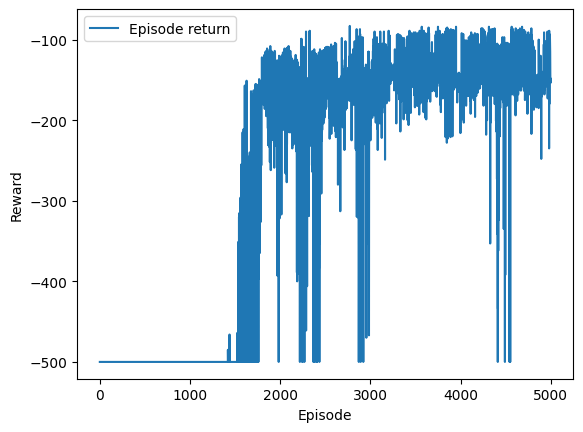

In [ ]:
rewards_dqn = []

for episode in range(num_episodes):
    state, _ = env.reset()
    total_reward = 0.0
    steps = 0
    done = False

    eps_t = decayed_epsilon(episode)
    while not done and steps < max_steps:
        action = epsilon_greedy(state, eps_t)
        next_state, reward, done, _, _ = env.step(action)

        replay_buffer.append((state, action, reward, next_state, 1.0 if done else 0.0))

        train_dqn()

        # global target update
        global_step += 1
        if global_step % target_update_freq == 0:
            q_target.load_state_dict(q_net.state_dict())

        state = next_state
        total_reward += reward
        steps += 1

    rewards_dqn.append(total_reward)

    if episode % 50 == 0:
        s_eval, _ = env.reset()
        eval_reward, eval_steps, done_eval = 0.0, 0, False
        while not done_eval and eval_steps < max_steps:
            a = epsilon_greedy(s_eval, 0.0)  # greedy
            s_eval, r, term, _, _ = env.step(a)
            done_eval = bool(term)
            eval_reward += r
            eval_steps += 1
        print(f"Ep {episode:4d} | Train Reward {total_reward:6.1f} | Steps {steps:3d} | Epsilon {eps_t:.3f} "
              f"| Eval Reward {eval_reward:6.1f} | Eval Steps {eval_steps:3d}")

plt.plot(rewards_dqn, label="Episode return")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.legend()
plt.show()


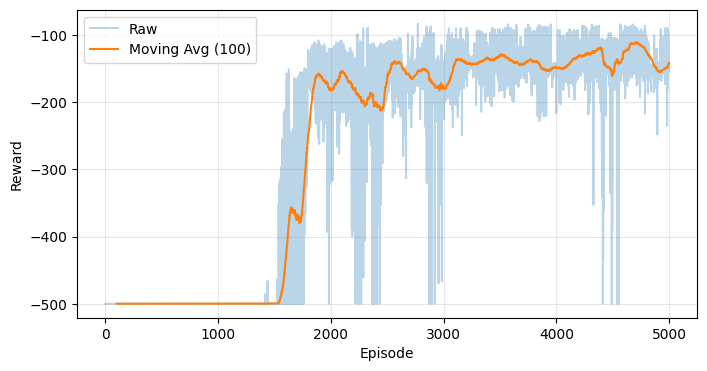

In [ ]:
window = 100  # smoothing window (episodes)
rewards_smooth = np.convolve(rewards_dqn, np.ones(window)/window, mode='valid')

plt.figure(figsize=(8,4))
plt.plot(rewards_dqn, alpha=0.3, label="Raw")
plt.plot(np.arange(window-1, len(rewards_dqn)), rewards_smooth, label=f"Moving Avg ({window})")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


3. **Short write-up** (also in the notebook):
   - **Performance of your DQN agent**: How quickly does it learn? Does it reach the goal consistently?
   - **Comparison with tile coding**:
     - Which representation learns faster?
     - Which one is more stable?
     - How do the function approximation choices (linear with tiles vs. neural network) affect generalization?
     - Did the NN require more tuning (learning rate, ε schedule) compared to tile coding?
   - **Insights**: What are the trade-offs between hand-crafted features (tiles) and learned features (neural networks)?


**Discussion**

My DQN agent takes a lot of time to learn. The code run for around 30 minutes. It does not reach the goal consistently. I feel like tile coding learns faster and is more stable than the neural network. The neural networks can make nonlinear approximations, so they should be better for affect generalization.

Regarding the tuning, both methods have multiple things that are user inputs. The tiles have the number and size of the tiles, while the neural networks have the number of layer, optimizer used, the nonlinear function used, and so on. In general, I think that the neural network has more hyperparameters and so, require more tuning.

Finally, the main trade-off between hand-crafted features and learned features
is the interpretability. The neural network is a black box, so it is really hard to understand why it does not work when that happens. On the other hand, it is capable of identifying patterns hidden to the user.

# Exercise 2: Deep Q-Learning (DQN) on LunarLander-v2

## Problem Description
In this exercise, you will implement **Deep Q-Learning (DQN)** to solve the classic control problem **LunarLander-v2** in Gym.

### The Task
The agent controls a lander that starts at the top of the screen and must safely land on the landing pad between two flags.

- **State space**: Continuous vector of 8 variables, including:
  - Position (x, y)
  - Velocity (x_dot, y_dot)
  - Angle and angular velocity
  - Left/right leg contact indicators
- **Action space**: Discrete, 4 actions
  - 0: do nothing
  - 1: fire left orientation engine
  - 2: fire main engine
  - 3: fire right orientation engine
- **Rewards**:
  - +100 to +140 for successful landing
  - -100 for crashing
  - Small negative reward for firing engines (fuel cost)
  - Episode ends when lander crashes or comes to rest

The goal is to train an agent that lands successfully **most of the time**.

---

## Algorithm: Deep Q-Learning
You will implement a **DQN agent** with the following components:

1. **Q-Network**
   - Neural network that approximates Q(s, a).
   - Input: state vector (8 floats).
   - Output: Q-values for 4 actions.
   - Suggested architecture: 2 hidden layers with 128 neurons each, ReLU activation.

2. **Target Network**
   - A copy of the Q-network that is updated less frequently (e.g., every 1000 steps).
   - Used for stable target computation.

3. **Replay Buffer**
   - Stores transitions `(s, a, r, s_next, done)`.
   - Sample random mini-batches to break correlation between consecutive samples.

4. **ε-Greedy Policy**
   - With probability ε, take a random action.
   - Otherwise, take `argmax_a Q(s, a)`.
   - Decay ε over time (e.g., from 1.0 → 0.05).

5. **Q-Learning Method**
   


**Final note:**
   No code base is necessary. At this point, you must know how to implement evertything.
   For reference, but not recommended ([Here](https://colab.research.google.com/drive/1Gl0kuln79A__hgf2a-_-mwoGISXQDK_X?authuser=1#scrollTo=8Sd0q9DG8Rt8&line=56&uniqifier=1) is a solution)

---
## Deliverables
1. **Code**:
- Q-network (PyTorch).
- Training loop with ε-greedy policy, target network, and Adam optimizer.

2. **Plots**:
- Episode returns vs training episodes.
- Evaluation performance with a greedy policy (ε = 0).

3. **Short Write-up (≤1 page)**:
- Did your agent learn to land consistently?  
- How many episodes did it take before you saw improvement?  
- What effect did replay buffer size, target update frequency, and learning rate have on stability?  
- Compare results across different runs (does it sometimes fail to converge?).

Compare this task with the **MountainCar-v0** problem you solved earlier:
- What is **extra** or more challenging in LunarLander?  
- Consider state dimensionality, number of actions, reward shaping, and the difficulty of exploration.  
- Why might DQN be necessary here, whereas simpler methods (like tile coding) could work for MountainCar?


Ep    0 | Train Reward -211.4 | Steps  95 | Epsilon 1.000 | Eval Reward -456.6 | Eval Steps  54
Ep   50 | Train Reward -104.7 | Steps  88 | Epsilon 0.952 | Eval Reward  -16.7 | Eval Steps 500
Ep  100 | Train Reward  -65.6 | Steps  59 | Epsilon 0.906 | Eval Reward   25.5 | Eval Steps 500
Ep  150 | Train Reward  -74.2 | Steps  62 | Epsilon 0.862 | Eval Reward -231.8 | Eval Steps 500
Ep  200 | Train Reward -114.6 | Steps 110 | Epsilon 0.821 | Eval Reward -1852.4 | Eval Steps 456
Ep  250 | Train Reward  -80.0 | Steps 127 | Epsilon 0.781 | Eval Reward -162.5 | Eval Steps 500
Ep  300 | Train Reward  -47.7 | Steps  65 | Epsilon 0.743 | Eval Reward  -27.3 | Eval Steps 301
Ep  350 | Train Reward  -36.5 | Steps 114 | Epsilon 0.708 | Eval Reward   18.7 | Eval Steps 500
Ep  400 | Train Reward  -23.8 | Steps 115 | Epsilon 0.674 | Eval Reward   37.1 | Eval Steps 500
Ep  450 | Train Reward  -24.8 | Steps  79 | Epsilon 0.641 | Eval Reward   16.8 | Eval Steps 500
Ep  500 | Train Reward  -92.9 | Steps  

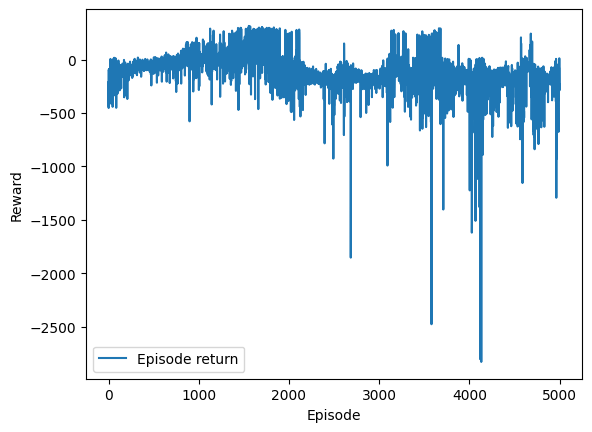

In [ ]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
from collections import deque
import matplotlib.pyplot as plt

# Env
env = gym.make("LunarLander-v3", render_mode="rgb_array")

n_actions = env.action_space.n
state_dim = env.observation_space.shape[0]

# Hyperparameters
gamma = 0.99
alpha = 0.001
epsilon = 1.0
epsilon_min = 0.01
epsilon_decay = 1e-3
num_episodes = 5000
batch_size = 64
replay_buffer_size = 50000
warmup_min = 1000
target_update_freq = 1000
global_step = 0
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Q-network
class QNetwork(nn.Module):
    def __init__(self, state_dim, n_actions):
        super().__init__()
        self.fc1 = nn.Linear(state_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 128)
        self.fc4 = nn.Linear(128, n_actions)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        return self.fc4(x)

q_net = QNetwork(state_dim, n_actions).to(device)
q_target = QNetwork(state_dim, n_actions).to(device)
q_target.load_state_dict(q_net.state_dict())
q_target.eval()

optimizer = optim.Adam(q_net.parameters(), lr=alpha)
loss_fn = nn.MSELoss()
replay_buffer = deque(maxlen=replay_buffer_size)

def epsilon_greedy(state, eps):
    if random.random() < eps:
        return env.action_space.sample()
    with torch.no_grad():
        s = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
        q_values = q_net(s)
        return int(torch.argmax(q_values, dim=1).item())

def decayed_epsilon(ep):
    # exponential decay from epsilon -> epsilon_min
    return epsilon_min + (epsilon - epsilon_min) * np.exp(-epsilon_decay * ep)

def train_dqn():
    if len(replay_buffer) < max(batch_size, warmup_min):
        return

    batch = random.sample(replay_buffer, batch_size)
    states, actions, rewards, next_states, dones = zip(*batch)

    states      = torch.tensor(np.array(states), dtype=torch.float32, device=device)
    next_states = torch.tensor(np.array(next_states), dtype=torch.float32, device=device)
    actions     = torch.tensor(actions, dtype=torch.long, device=device)
    rewards     = torch.tensor(rewards, dtype=torch.float32, device=device)
    dones       = torch.tensor(dones, dtype=torch.float32, device=device)

    # Q(s,a)
    q_sa = q_net(states).gather(1, actions.unsqueeze(1)).squeeze(1)

    with torch.no_grad():
        # Double DQN target
        next_best = q_net(next_states).argmax(dim=1, keepdim=True)
        next_q = q_target(next_states).gather(1, next_best).squeeze(1)
        targets = rewards + gamma * next_q * (1.0 - dones)

    loss = loss_fn(q_sa, targets)
    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(q_net.parameters(), 10.0)
    optimizer.step()

rewards_dqn = []

for episode in range(num_episodes):
    state, _ = env.reset()
    total_reward = 0.0
    steps = 0
    done = False

    eps_t = decayed_epsilon(episode)

    while not done:
        action = epsilon_greedy(state, eps_t)
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = bool(terminated or truncated)

        # store transition (note: dones as 1.0/0.0 floats)
        replay_buffer.append((state, action, reward, next_state, 1.0 if done else 0.0))

        train_dqn()

        # global target update
        global_step += 1
        if global_step % target_update_freq == 0:
            q_target.load_state_dict(q_net.state_dict())

        state = next_state
        total_reward += reward
        steps += 1

    rewards_dqn.append(total_reward)

    if episode % 50 == 0:
        s_eval, _ = env.reset()
        eval_reward, eval_steps, done_eval = 0.0, 0, False
        while not done_eval and eval_steps < max_steps:
            a = epsilon_greedy(s_eval, 0.0)  # greedy
            s_eval, r, term, _, _ = env.step(a)
            done_eval = bool(term)
            eval_reward += r
            eval_steps += 1
        print(f"Ep {episode:4d} | Train Reward {total_reward:6.1f} | Steps {steps:3d} | Epsilon {eps_t:.3f} "
              f"| Eval Reward {eval_reward:6.1f} | Eval Steps {eval_steps:3d}")

plt.plot(rewards_dqn, label="Episode return")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.legend()
plt.show()


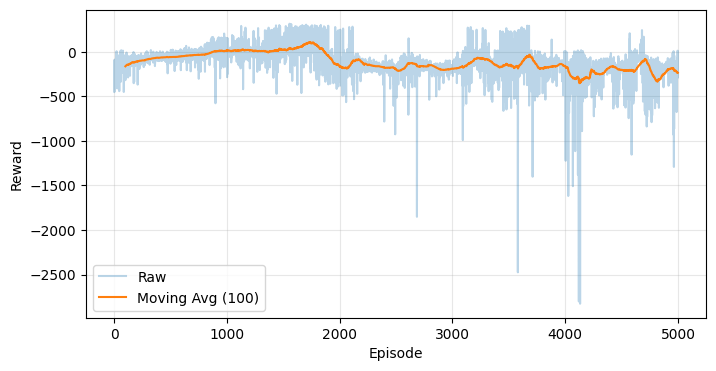

In [ ]:
window = 100  # smoothing window (episodes)
rewards_smooth = np.convolve(rewards_dqn, np.ones(window)/window, mode='valid')

plt.figure(figsize=(8,4))
plt.plot(rewards_dqn, alpha=0.3, label="Raw")
plt.plot(np.arange(window-1, len(rewards_dqn)), rewards_smooth, label=f"Moving Avg ({window})")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

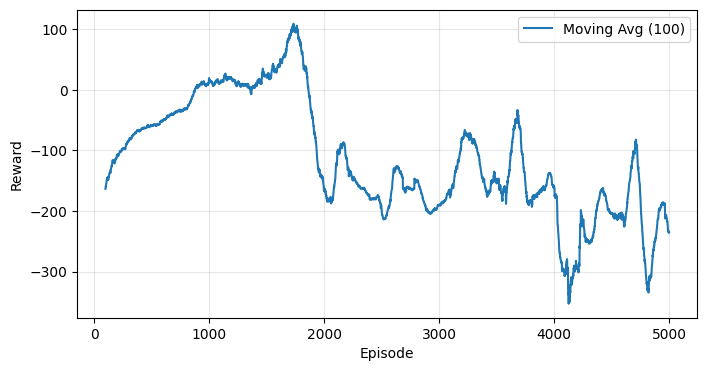

In [ ]:
plt.figure(figsize=(8,4))
plt.plot(np.arange(window-1, len(rewards_dqn)), rewards_smooth, label=f"Moving Avg ({window})")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

Frequency of NN update = 500,
Learning rate = 0.1

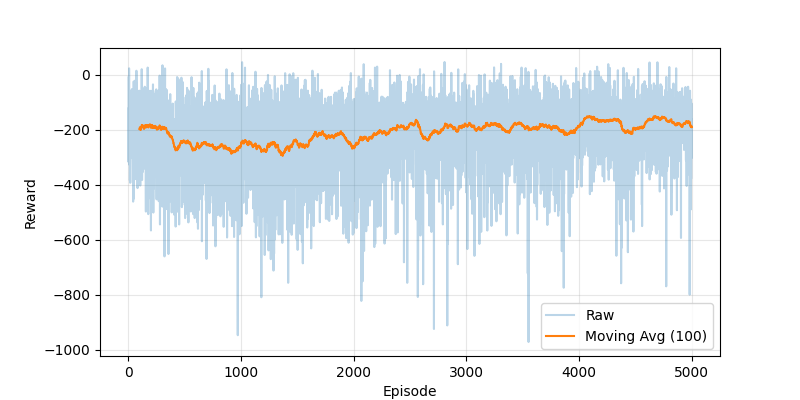

# The simulation took more than 2 hours, so the rest of the results were obtained in my local computer. The following results were obtained using the same code, with different values of 'target_update_freq' and 'alpha'.

Frequency of NN update = 500,
Learning rate = 0.01

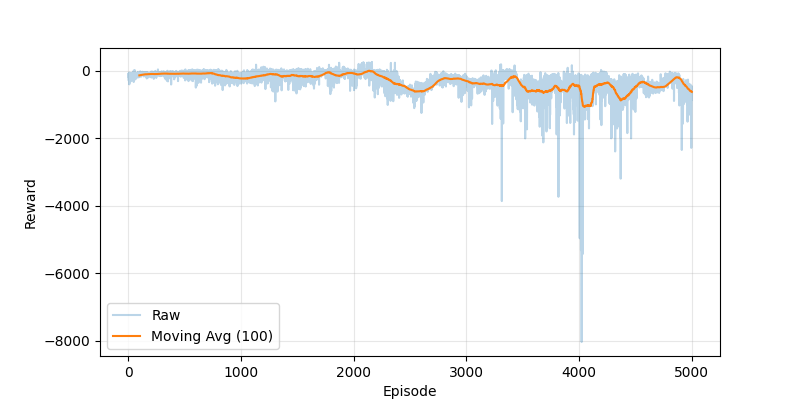

Frequency of NN update = 500,
Learning rate = 0.001

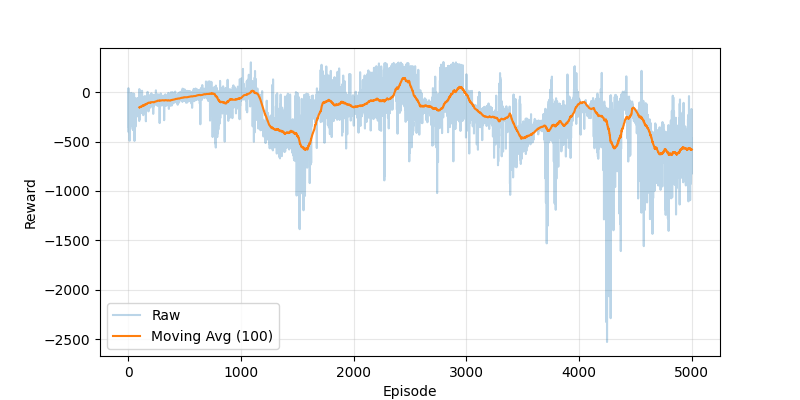

Frequency of NN update = 1000,
Learning rate = 0.1

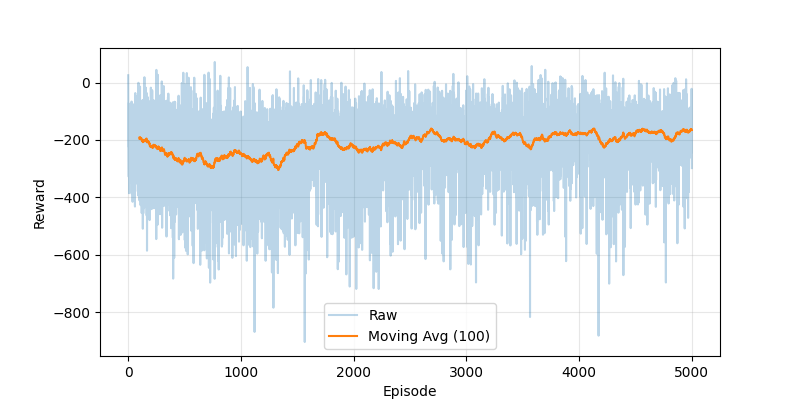

Frequency of NN update = 1000,
Learning rate = 0.01

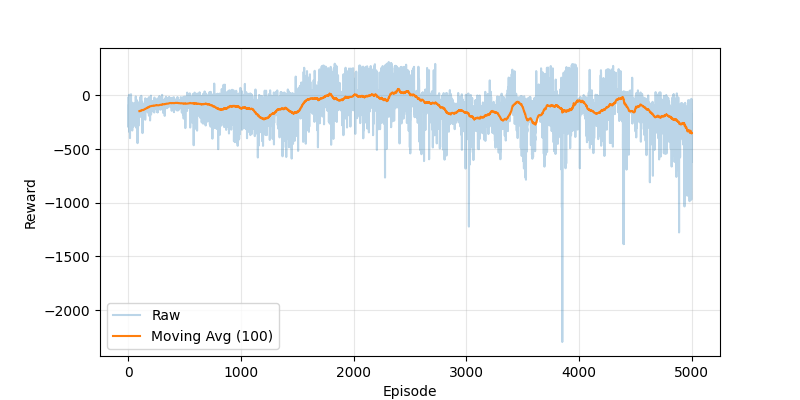

Frequency of NN update = 1000,
Learning rate = 0.001

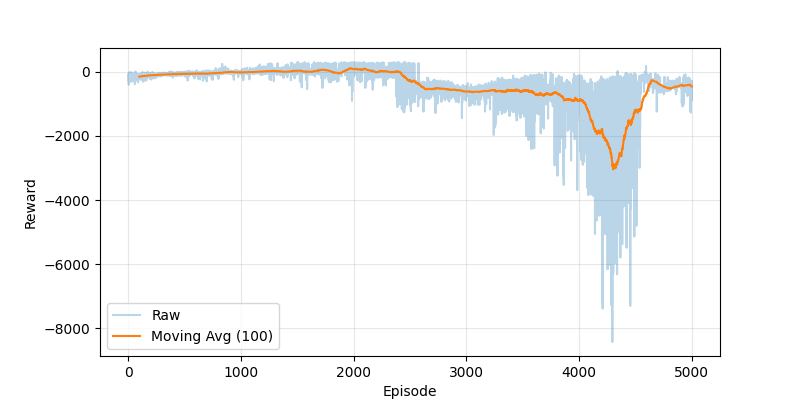

Frequency of NN update = 2000,
Learning rate = 0.1

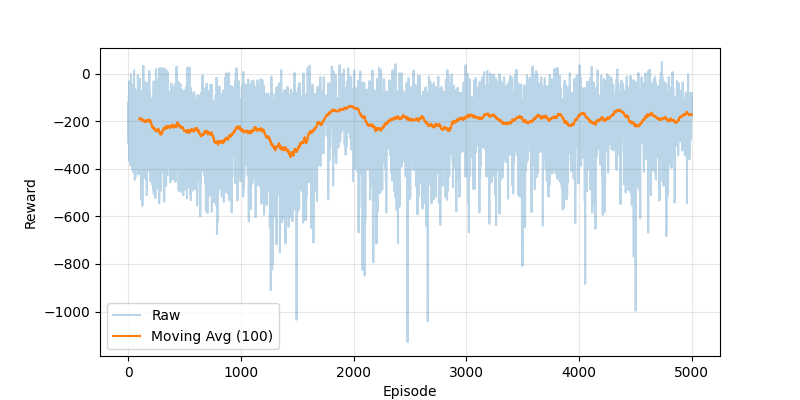

Frequency of NN update = 2000,
Learning rate = 0.01

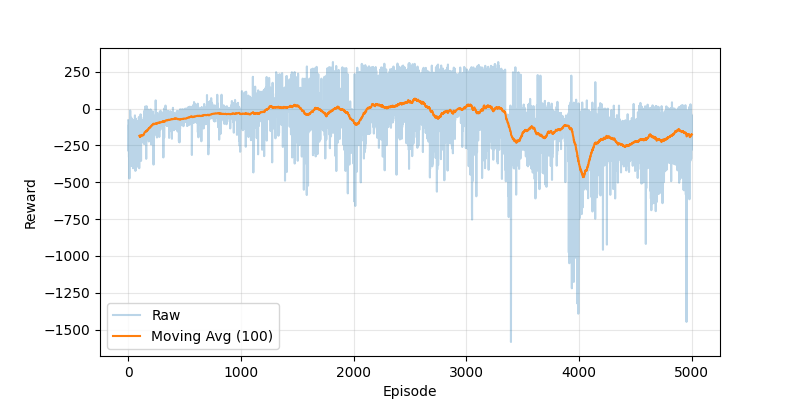

Frequency of NN update = 2000,
Learning rate = 0.001
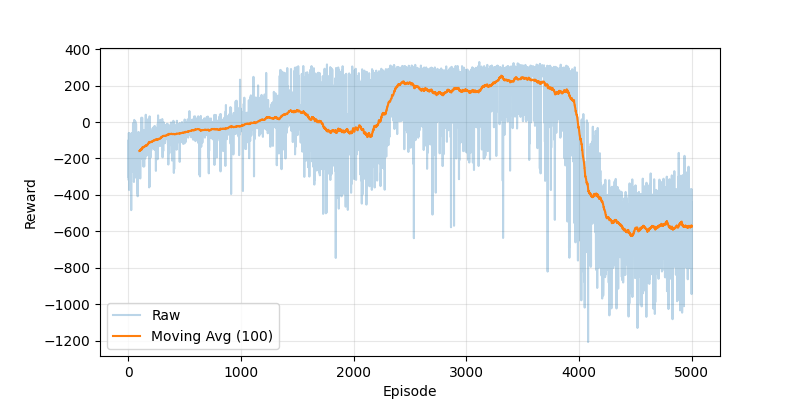

3. **Short Write-up (≤1 page)**:
- Did your agent learn to land consistently?  
- How many episodes did it take before you saw improvement?  
- What effect did replay buffer size, target update frequency, and learning rate have on stability?  
- Compare results across different runs (does it sometimes fail to converge?).

Compare this task with the **MountainCar-v0** problem you solved earlier:
- What is **extra** or more challenging in LunarLander?  
- Consider state dimensionality, number of actions, reward shaping, and the difficulty of exploration.  
- Why might DQN be necessary here, whereas simpler methods (like tile coding) could work for MountainCar?


**Discussion**

The agent for LunarLander did not learn to land consistently across runs. During training on Google Colab (target_update_freq = 1000, alpha = 0.001), the agent initially improved for the first ~2000 episodes, reaching higher rewards. However, after that point, learning became unstable and oscillatory. Since the code run for ≈ 2 hours in Colab, the rest of the simulations where done in my local computer, where each run took ≈ 30 minutes. The same oscillatory pattern was observed for many combinations of learning rate and target-network update frequency, even when the target_update_freq = 1000, alpha = 0.001 was re-done using my local computer.

Higher learning rates accelerated improvement early on but also led to larger oscillations, while smaller rates (0.001) produced very slow learning. A smaller target-update frequency also caused average-reward oscillations. More stable performance was obtained with target updates every 1000–2000 steps and a learning rate of 0.1.

Comparison with the MountainCar experiment:

The state dimension in the LunarLander environmenr is 8 versus 2 in MountainCar. Its action space is also biiger, going from three to four. This increases the total state–action space exponentially, making exploration of the whole space impossible. Another difference is the relationship between the states. In the MountainCar environment, the car can move right, left of do nothing. That means that then it is moving left, it is not moving right or doing nothing. In the LunarLander environment, some states are decupled, meaning that the spaceship can fire multiple engines at the same time. Another difference with the MountainCar is that the LunarLanding can fail do to crashing and not only run out of steps (I read this is a non-linear effect and makes things harder). That is why a DQN is used, since it can hanndle the 8 inputs and 4 outputs easily. Also, the neural network can catch hidden relationships between the inputs, invisible to humans, to make better predictions. If I try to use tile coding here following the reasoning used for MountainCar, I would need tiles with 8 dimensions (one per state) and 4 sets (one per action). Probably there is a better way to deal with all the states an actions, but there is a clear issue with the size of the system, which requires a lot of tiles and a huge number of possible states. That approach seems unfeasible.
